## Heat Eq with 2-parameter kernel


The heat equation is a parabolic partial differential equation that describes the distribution of heat (or variation in temperature) in a given region over time. The general form of the equation in any coordinate system is given by:

\begin{align*}
\frac{\partial u}{\partial t} - \phi \nabla^2 u = f
\end{align*}

We will work here with the heat equation in one spatial dimension. This can be formulated as:

\begin{align*}
\mathcal{L}_{\bar{x}}^{\phi}u(\bar{x}) = \frac{\partial}{\partial t}u(\bar{x}) - \phi \frac{\partial^2}{\partial x^2}u(\bar{x}) = f(\bar{x})
\end{align*}
, where $\bar{x} = (t, x) \in \mathbb{R}^2$.


The fundamental solution to the heat equation gives us:

\begin{align*}
u(x,t) &= e^{-t}sin(2\pi x) \\
f(x,t) &= e^{-t}(4\pi^2 - 1)sin(2\pi x)
\end{align*}


#### Simulate data

In [2]:
import time
import numpy as np
import sympy as sp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [3]:
n = 10
np.random.seed(int(time.time()))
t = np.random.rand(n)
x = np.random.rand(n)

In [4]:
y_u = np.multiply(np.exp(-t), np.sin(2*np.pi*x))
y_f = (4*np.pi**2 - 1) * np.multiply(np.exp(-t), np.sin(2*np.pi*x))

#### Evaluate kernels


1. $k_{uu}(x_i, x_j, t_i, t_j; \theta) =  e^ \left[ -\theta_1 (x_i-x_j)^2 - \theta_2 (t_i-t_j)^2 \right]$
2. $k_{ff}(\bar{x}_i,\bar{x}_j;\theta,\phi) = \mathcal{L}_{\bar{x}_i}^\phi \mathcal{L}_{\bar{x}_j}^\phi k_{uu}(\bar{x}_i, \bar{x}_j; \theta) = \mathcal{L}_{\bar{x}_i}^\phi \left[ \frac{\partial}{\partial t_j}k_{uu} - \phi \frac{\partial^2}{\partial x_j^2} k_{uu} \right] \\
= \frac{\partial}{\partial t_i}\frac{\partial}{\partial t_j}k_{uu} - \phi \left[ \frac{\partial}{\partial t_i}\frac{\partial^2}{\partial x_j^2}k_{uu} + \frac{\partial^2}{\partial x_i^2}\frac{\partial}{\partial t_j}k_{uu} \right] + \phi^2 \frac{\partial^2}{\partial x_i^2}\frac{\partial^2}{\partial x_j^2}k_{uu}$
3. $k_{fu}(\bar{x}_i,\bar{x}_j;\theta,\phi) = \mathcal{L}_{\bar{x}_i}^\phi k_{uu}(\bar{x}_i, \bar{x}_j; \theta) 
= \frac{\partial}{\partial t_i}k_{uu} - \phi \frac{\partial^2}{\partial x_i^2}k_{uu}$

In [5]:
x_i, x_j, t_i, t_j, theta1, theta2, phi = sp.symbols('x_i x_j t_i t_j theta1 theta2 phi')

In [5]:
kuu_sym = sp.exp(-theta1*(x_i - x_j)**2 - theta2*(t_i - t_j)**2)
kuu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta1, theta2), kuu_sym, "numpy")
def kuu(t, x, theta1, theta2):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kuu_fn(x[i], x[j], t[i], t[j], theta1, theta2)
    return k

In [6]:
kff_sym = sp.diff(kuu_sym, t_j, t_i) \
        - phi*sp.diff(kuu_sym,x_j,x_j,t_i) \
        - phi*sp.diff(kuu_sym,t_j,x_i,x_i) \
        + phi**2*sp.diff(kuu_sym,x_j,x_j,x_i,x_i)
kff_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta1, theta2, phi), kff_sym, "numpy")
def kff(t, x, theta1, theta2, p):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kff_fn(x[i], x[j], t[i], t[j], theta1, theta2, p)
    return k

In [7]:
kfu_sym = sp.diff(kuu_sym,t_i) - phi*sp.diff(kuu_sym,x_i,x_i)
kfu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta1, theta2, phi), kfu_sym, "numpy")
def kfu(t, x, theta1, theta2, p):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kfu_fn(x[i], x[j], t[i], t[j], theta1, theta2, p)
    return k

In [8]:
def kuf(t, x, theta1, theta2, p):
    return kfu(t, x, theta1, theta2, p).T

#### create covariance matrix and NLML

```
params = [sig_u, l_u, phi]
```

In [9]:
def nlml(params, t, x, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [
            kuu(t, x, params[0], params[1]) + s*np.identity(x.size),
            kuf(t, x, params[0], params[1], params[2])
        ],
        [
            kfu(t, x, params[0], params[1], params[2]),
            kff(t, x, params[0], params[1], params[2]) + s*np.identity(x.size)
        ]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

#### Optimise hyperparameters

In [10]:
nlml((1,1,0), t, x, y_u, y_f, 1e-6)

16.254927845182515

In [11]:
%%timeit
nlml_wp = lambda params: nlml(params, t, x, y_u, y_f, 1e-7)
minimize(
    nlml_wp,
    np.random.rand(3),
    method="Nelder-Mead",
    options={'maxiter' : 5000, 'fatol' : 0.001})

2.15 s ± 588 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
def minimize_restarts(t, x, y_u, y_f, n = 10):
    nlml_wp = lambda params: nlml(params, t, x, y_u, y_f, 1e-7)
    all_results = []
    for it in range(0,n):
        all_results.append(
            minimize(
                nlml_wp,
                np.random.rand(3),
                method="Nelder-Mead",
                options={'maxiter' : 5000, 'fatol' : 0.001}))
    filtered_results = [m for m in all_results if 0 == m.status]
    return min(filtered_results, key = lambda x: x.fun)

In [13]:
m = minimize_restarts(t, x, y_u, y_f, 20)
m

 final_simplex: (array([[ 1.47053851, -1.32523218, -0.01503347],
       [ 1.47056756, -1.3253114 , -0.0150344 ],
       [ 1.47057814, -1.32527798, -0.01503465],
       [ 1.47056073, -1.32526969, -0.01503602]]), array([-1.7497511 , -1.74975109, -1.74975108, -1.74975108]))
           fun: -1.749751099431128
       message: 'Optimization terminated successfully.'
          nfev: 181
           nit: 102
        status: 0
       success: True
             x: array([ 1.47053851, -1.32523218, -0.01503347])

##### Estimated value of $\alpha$

In [14]:
np.exp(m.x[2])

0.9850789679315667

#### Analysis

##### Contour lines for likelihood

In [15]:
delta = 0.01
theta1_range = np.arange(1, 2, delta)
theta2_range = np.arange(-2, 0, delta)
theta1_mesh, theta2_mesh = np.meshgrid(theta1_range, theta2_range)
nlml_mesh_fn = lambda mesh1, mesh2: nlml(np.array([mesh1, mesh2, 0]), t, x, y_u, y_f, 1e-7)
nlml_mesh = np.zeros(theta1_mesh.shape)
for i in range(nlml_mesh.shape[0]):
    for j in range(nlml_mesh.shape[1]):
        nlml_mesh[i][j] = nlml_mesh_fn(theta1_mesh[i][j], theta2_mesh[i][j])

In [16]:
contour_range = np.logspace(0, np.log(np.max(nlml_mesh) - np.min(nlml_mesh)), num=15, base=np.exp(1))
contour_range = np.min(nlml_mesh) + contour_range

f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
f.suptitle("NLML contour lines")
cs1 = ax1.contour(theta1_mesh, theta2_mesh, nlml_mesh, contour_range)
plt.clabel(cs1, inline=1, fontsize=5)
ax1.set(xlabel= r"$ln(\theta_1)$", ylabel= r"$ln(\theta_2)$")
cs2 = ax2.contour(np.exp(theta1_mesh), np.exp(theta2_mesh), nlml_mesh, contour_range)
plt.clabel(cs1, inline=1, fontsize=5)
ax2.set(xlabel= r"$\theta_1$", ylabel= r"$\theta_2$")

[<matplotlib.text.Text at 0x1130278d0>, <matplotlib.text.Text at 0x11301b208>]

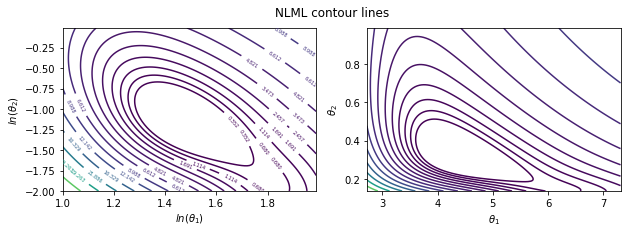

In [17]:
plt.show()

##### Profile likelihood

In [18]:
theta1_optim = np.zeros(theta1_range.size)
for i in range(theta1_range.size):
    nlml_opt_theta2 = lambda t2 : nlml(np.array([theta1_range[i], t2, 0]), t, x, y_u, y_f, 1e-7)
    m = minimize_scalar(nlml_opt_theta2)
    theta1_optim[i] = m['fun']

In [19]:
theta2_optim = np.zeros(theta2_range.size)
for i in range(theta2_range.size):
    def nlml_opt_theta1(t1):
        return nlml(np.array([t1, theta2_range[i], 0]), t, x, y_u, y_f, 1e-7)
    m = minimize_scalar(nlml_opt_theta1)
    theta2_optim[i] = m['fun']

In [20]:
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10,3))
f.suptitle("Profile likelihood")
ax1.plot(theta1_range, theta1_optim)
ax1.set(xlabel= r"$ln(\theta_1)$", ylabel= "nlml")
ax2.plot(theta2_range, theta2_optim, 'r')
ax2.set(xlabel= r"$ln(\theta_2)$", ylabel= "nlml")

[<matplotlib.text.Text at 0x1133e3470>, <matplotlib.text.Text at 0x1133d6390>]

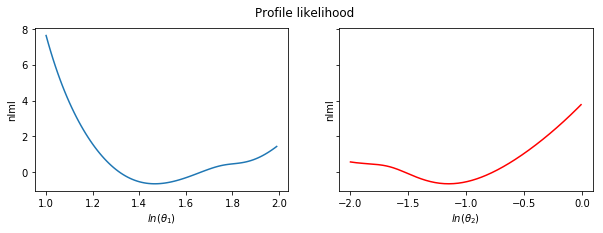

In [21]:
plt.show()

##### With the full kernel

In [16]:
theta, l1, l2 = sp.symbols('theta l1 l2')

kuu_sym = theta*sp.exp(-(x_i - x_j)**2/(2*l1) - (t_i - t_j)**2/(2*l2))
kuu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l1, l2), kuu_sym, "numpy")
def kuu(t, x, theta, l1, l2):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kuu_fn(x[i], x[j], t[i], t[j], theta, l1, l2)
    return k

kff_sym = sp.diff(kuu_sym, t_j, t_i) \
        - phi*sp.diff(kuu_sym,x_j,x_j,t_i) \
        - phi*sp.diff(kuu_sym,t_j,x_i,x_i) \
        + phi**2*sp.diff(kuu_sym,x_j,x_j,x_i,x_i)
kff_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l1, l2, phi), kff_sym, "numpy")
def kff(t, x, theta, l1, l2, p):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kff_fn(x[i], x[j], t[i], t[j], theta, l1, l2, p)
    return k

kfu_sym = sp.diff(kuu_sym,t_i) - phi*sp.diff(kuu_sym,x_i,x_i)
kfu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l1, l2, phi), kfu_sym, "numpy")
def kfu(t, x, theta, l1, l2, p):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kfu_fn(x[i], x[j], t[i], t[j], theta, l1, l2, p)
    return k

def kuf(t, x, theta, l1, l2, p):
    return kfu(t, x, theta, l1, l2, p).T

def nlml(params, t, x, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [
            kuu(t, x, params[0], params[1], params[2]) + s*np.identity(x.size),
            kuf(t, x, params[0], params[1], params[2], params[3])
        ],
        [
            kfu(t, x, params[0], params[1], params[2], params[3]),
            kff(t, x, params[0], params[1], params[2], params[3]) + s*np.identity(x.size)
        ]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [17]:
nlml((1,1,1,0), t, x, y_u, y_f, 1e-6)

4186823.8705198932

In [15]:
%%timeit
nlml_wp = lambda params: nlml(params, t, x, y_u, y_f, 1e-7)
minimize(
    nlml_wp,
    np.random.rand(4),
    method="Nelder-Mead",
    options={'maxiter' : 5000, 'fatol' : 0.001})

5.91 s ± 2.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
